# Gaussian process visualization for functions with 2 continuous and 1 discrete input feature

## GP model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from botorch.models import SingleTaskGP
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

In [10]:
from botorch.models import MixedSingleTaskGP


# Step 1: Generate dummy data
def generate_dummy_data(num_samples=50):
    x = np.random.uniform(0, 1, (num_samples, 2))
    d = np.random.randint(0, 3, num_samples).reshape(-1, 1)  # Discrete dimension with values in {0, 1, 2}
    inputs = np.hstack([x, d])
    targets = np.sin(2 * np.pi * inputs[:, 0]) + np.cos(2 * np.pi * inputs[:, 1]) + 0.1 * inputs[:, 2] + 0.1 * np.random.randn(num_samples)
    return torch.tensor(inputs, dtype=torch.float64), torch.tensor(targets, dtype=torch.float64).unsqueeze(-1)

train_x, train_y = generate_dummy_data()

# Step 2: Instantiate and train the GP model

categorical_features = [2]  # The index of the discrete dimension
gp_mixed_model = MixedSingleTaskGP(train_X=train_x, train_Y=train_y, cat_dims=categorical_features)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)
gp_model = SingleTaskGP(train_x, train_y)

gp_none = SingleTaskGP(torch.zeros(1, 3, dtype=torch.float64), torch.zeros(1, 1, dtype=torch.float64))

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0350], dtype=torch.float64), std = tensor([0.9602], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


In [11]:
# Highlighted point
highlight_point = (0.5, 0.5, 0)
# Define ranges and discrete values
x_range = (0, 1)
y_range = (0, 1)
d_values = 2  # Example discrete values

## Surface and Contour plots

In [12]:
from typing import Tuple, Optional
from botorch.models.gpytorch import GPyTorchModel


## Surface and Contour plots
def plot_gp_contours_with_uncertainty(gp_model: GPyTorchModel, x_range: Tuple[float, float],
                                      y_range: Tuple[float, float], d_values: int,
                                      highlight_point: Optional[Tuple[float, float, float]] = None,
                                      title: str = '') -> None:
    """
    Plots the contour of the GP mean and uncertainty for different discrete values.

    :param gp_model: Trained GP model.
    :param x_range: Range of x values.
    :param y_range: Range of y values.
    :param d_values: List of discrete values.
    :param highlight_point: Tuple of (x1, x2) values to highlight on the plot.
    :param title: Title for the plots.
    """
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig, axes = plt.subplots(2, d_values, figsize=(15, 10))

    for d in range(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)

        with torch.no_grad():
            posterior = gp_model.posterior(input_tensor)
            gp_mean, gp_var = posterior.mean, posterior.variance

        Z_mean = gp_mean.view(X.shape).numpy()
        Z_std = gp_var.view(X.shape).sqrt().numpy()  # Standard deviation

        # Mean contour plot
        ax_mean = axes[0, d]
        contour_mean = ax_mean.contourf(X, Y, Z_mean, cmap='viridis', alpha=0.8)
        ax_mean.contour(X, Y, Z_mean, colors='k', linewidths=0.5)
        ax_mean.set_title(f'{title} Mean, a={d}')
        fig.colorbar(contour_mean, ax=ax_mean)
        ax_mean.set_xlabel('s1')
        ax_mean.set_ylabel('s2')

        # Standard deviation contour plot
        ax_std = axes[1, d]
        contour_std = ax_std.contourf(X, Y, Z_std, cmap='viridis', alpha=0.8)
        ax_std.contour(X, Y, Z_std, colors='k', linewidths=0.5)
        ax_std.set_title(f'{title} Std Dev, a={d}')
        fig.colorbar(contour_std, ax=ax_std)
        ax_std.set_xlabel('s1')
        ax_std.set_ylabel('s2')

        # Highlight the specified point if provided
        if highlight_point:
            ax_mean.scatter(highlight_point[0], highlight_point[1], color='red' if d == highlight_point[2] else 'blue',
                            label='Highlight Point')
            ax_std.scatter(highlight_point[0], highlight_point[1], color='red' if d == highlight_point[2] else 'blue',
                           label='Highlight Point')

    plt.show()


# noinspection DuplicatedCode
def plot_gp_surface_with_uncertainty(gp_model: GPyTorchModel, x_range: Tuple[float, float],
                                     y_range: Tuple[float, float], d_values: int,
                                     highlight_point: Optional[Tuple[float, float, float]] = None,
                                     title: str = '') -> None:
    """
    Plots the 3D surface of the GP mean and uncertainty for different discrete values.

    :param gp_model: Trained GP model.
    :param x_range: Range of x values.
    :param y_range: Range of y values.
    :param d_values: List of discrete values.
    :param highlight_point: Tuple of (x1, x2) values to highlight on the plot.
    :param title: Title for the plots.
    """
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig = plt.figure(figsize=(15, 10))

    # Calculate the minimum and maximum of the GP mean and standard deviation
    z_mean_min = np.inf
    z_mean_max = -np.inf
    z_std_min = np.inf
    z_std_max = -np.inf

    for d in range(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)

        with torch.no_grad():
            posterior = gp_model.posterior(input_tensor)
            gp_mean, gp_var = posterior.mean, posterior.variance

        Z_mean = gp_mean.view(X.shape).numpy()
        Z_std = gp_var.view(X.shape).sqrt().numpy()  # Standard deviation

        # Update the minimum and maximum values
        z_mean_min = min(z_mean_min, np.min(Z_mean))
        z_mean_max = max(z_mean_max, np.max(Z_mean))
        z_std_min = min(z_std_min, np.min(Z_std))
        z_std_max = max(z_std_max, np.max(Z_std))

    for d in range(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)

        with torch.no_grad():
            posterior = gp_model.posterior(input_tensor)
            gp_mean, gp_var = posterior.mean, posterior.variance

        Z_mean = gp_mean.view(X.shape).numpy()
        Z_std = gp_var.view(X.shape).sqrt().numpy()  # Standard deviation

        # Mean surface plot
        ax_mean = fig.add_subplot(2, d_values, d + 1, projection='3d')
        ax_mean.plot_surface(X, Y, Z_mean, cmap='viridis')
        ax_mean.set_title(f'{title} Mean, a={d}')
        ax_mean.set_xlabel('s1')
        ax_mean.set_ylabel('s2')
        ax_mean.set_zlabel('μ(s1, s2, a)')
        # ax_mean.set_zlim(z_mean_min, z_mean_max)  # Adjust z-range

        # Standard deviation surface plot
        ax_std = fig.add_subplot(2, d_values, d + 1 + d_values, projection='3d')
        ax_std.plot_surface(X, Y, Z_std, cmap='viridis')
        ax_std.set_title(f'{title} Std Dev, a={d}')
        ax_std.set_xlabel('s1')
        ax_std.set_ylabel('s2')
        ax_std.set_zlabel('σ(s1, s2, a)')
        # ax_std.set_zlim(z_std_min, z_std_max)  # Adjust z-range

        # Highlight the specified point if provided
        if highlight_point:
            x_val = highlight_point[0]
            y_val = highlight_point[1]
            z_range_mean = np.linspace(z_mean_min, z_mean_max, 100)
            z_range_std = np.linspace(z_std_min, z_std_max, 100)
            ax_mean.plot(np.full_like(z_range_mean, x_val), np.full_like(z_range_mean, y_val), z_range_mean,
                         color='red' if d == highlight_point[2] else 'blue', linewidth=2, alpha=1)
            ax_std.plot(np.full_like(z_range_std, x_val), np.full_like(z_range_std, y_val), z_range_std,
                        color='red' if d == highlight_point[2] else 'blue', linewidth=2, alpha=1)

    plt.show()


def plot_sample_from_gp_posterior(gp_model: GPyTorchModel, x_range: Tuple[float, float],
                                  y_range: Tuple[float, float], d_values: int, num_samples: int = 1) -> None:
    """
    Samples and plots functions from the GP posterior for different discrete values.

    :param gp_model: Trained GP model.
    :param x_range: Range of x values.
    :param y_range: Range of y values.
    :param d_values: List of discrete values.
    :param num_samples: Number of samples to draw from the posterior.
    """
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig = plt.figure(figsize=(15, 5))

    for d in range(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)

        gp_model.eval()  # Put the model in evaluation mode
        gp_model.likelihood.eval()  # Put the likelihood in evaluation mode

        with torch.no_grad():
            posterior = gp_model.posterior(input_tensor)
            samples = posterior.rsample(sample_shape=torch.Size([num_samples]))

        for j in range(num_samples):
            Z_sample = samples[j].view(X.shape).numpy()

            ax = fig.add_subplot(1, d_values, d + 1, projection='3d')
            ax.plot_surface(X, Y, Z_sample, cmap='viridis')
            ax.set_title(f'Sample action-value function {j + 1}, a={d}')
            ax.set_xlabel('s1')
            ax.set_ylabel('s2')
            ax.set_zlabel('q(s1, s2, a)')

    plt.show()


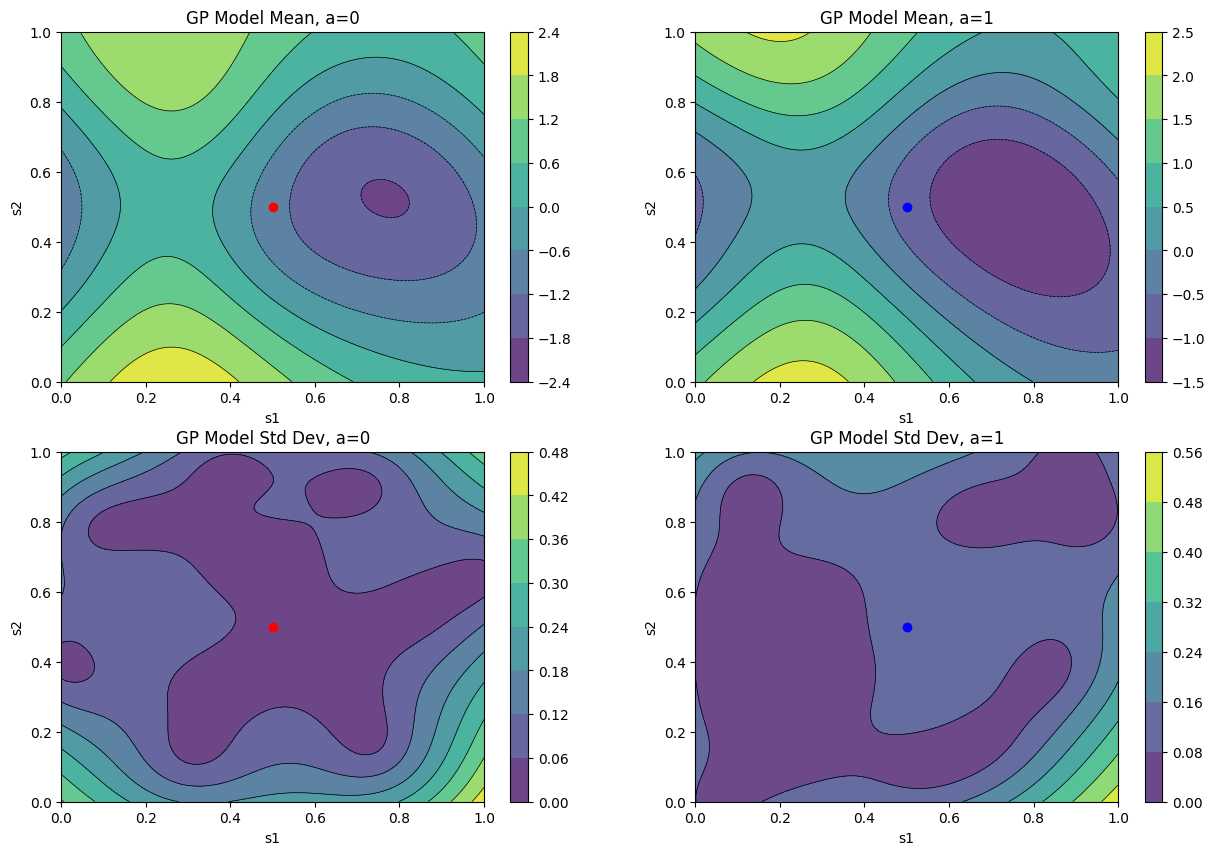

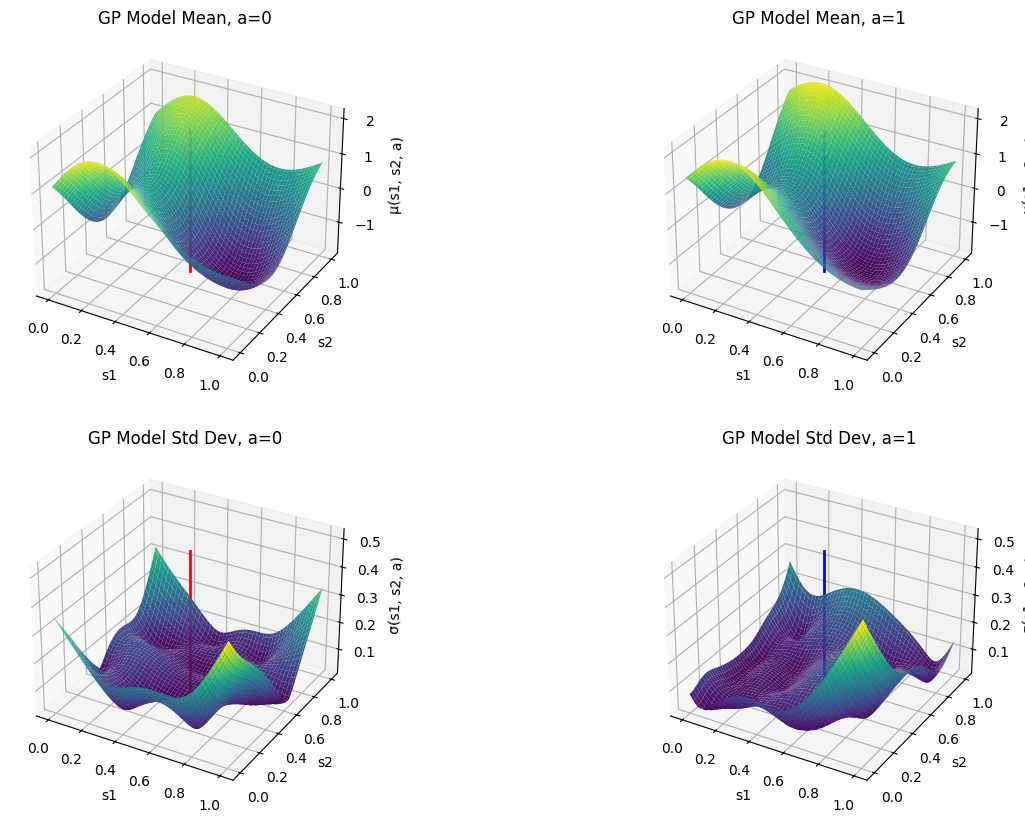

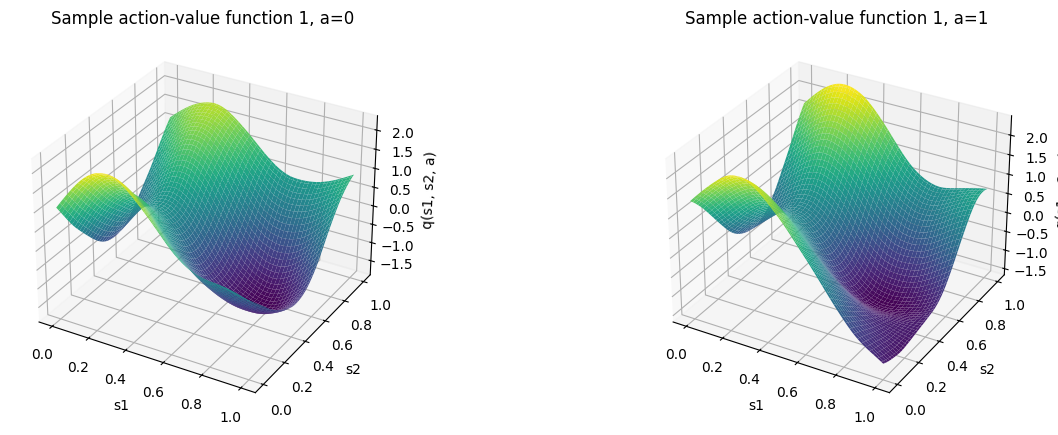

In [13]:
# Contour + surface plot
# Plot GP contours with uncertainty including the highlighted point
plot_gp_contours_with_uncertainty(gp_mixed_model, x_range, y_range, d_values, highlight_point=highlight_point, title='GP Model')

# Plot GP surface with uncertainty including the highlighted point
plot_gp_surface_with_uncertainty(gp_mixed_model, x_range, y_range, d_values, highlight_point=highlight_point, title='GP Model')

plot_sample_from_gp_posterior(gp_mixed_model, x_range, y_range, d_values)

## Gaussian visualization for highlight point with variable number of discrete features

In [18]:
from typing import Tuple
from botorch.models.gpytorch import GPyTorchModel


def plot_gp_point_distribution(gp_model: GPyTorchModel, point: Tuple[float, float], d_values: int, title: str = '') -> None:
    """
    Plots the mean and standard deviation of a specific point (x1, x2) as a univariate Gaussian distribution for each d value.

    :param gp_model: Trained GP model.
    :param point: Tuple of (x1, x2) values for the point of interest.
    :param d_values: Number of discrete values for d.
    :param title: Title for the plot.
    """
    x1 = point[0]
    x2 = point[1]

    # Initialize minimum and maximum x-values
    x_min = np.inf
    x_max = -np.inf

    fig, ax = plt.subplots(figsize=(10, 6))

    for d in range(d_values):
        with torch.no_grad():
            posterior = gp_model.posterior(torch.tensor([[x1, x2, d]], dtype=torch.float))
            mean = posterior.mean.item()
            std = posterior.variance.sqrt().item()

        # Calculate the range of x-values based on mean and standard deviation
        x_range = np.linspace(mean - 3 * std, mean + 3 * std, 100)
        x_min = min(x_min, np.min(x_range))
        x_max = max(x_max, np.max(x_range))

        # Calculate the corresponding probability density function values using the Gaussian distribution formula
        pdf_values = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_range - mean) / std) ** 2)

        # Plot the mean as a vertical line
        ax.axvline(x=mean, color='red', linestyle='--', label=f'Mean, d={d}')

        # Plot the standard deviation as a shaded region around the mean
        ax.fill_between(x_range, pdf_values, color='lightblue', alpha=0.3, label=f'Std Dev, d={d}')

    # Set the x-axis limits based on the minimum and maximum x-values
    ax.set_xlim(x_min, x_max)

    ax.set_title(title)
    ax.set_xlabel('q(s1, s2, .)')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.show()

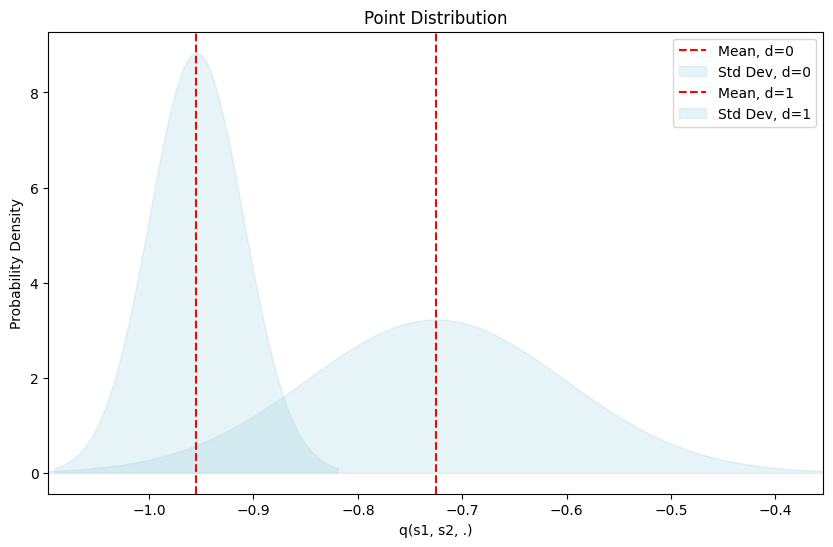

In [19]:
point_of_interest = (0.5, 0.5)
plot_gp_point_distribution(gp_mixed_model, point_of_interest, 2, title='Point Distribution')